In [52]:
#In the begining, ther is time
import time

In [53]:
#Quality of life
#Some things we do generate a lot of warnings, and it just becomes clutter.
import warnings
warnings.filterwarnings("ignore")
#I like it when my notebook helps me out
%config IPCompleter.greedy=True
#Sometiems you just need to print pretty
from pprint import pprint
#Lots of these operations take many minutes to complete. So it behooves us to pickle the outputs and just unpickle them each time we re-open the notebook
import pickle


Data is from: https://www.kaggle.com/datasets/toygarr/datasets-for-natural-language-processing

Dataset is from a collection of sentiment datasets, but we just want to play with the food one for now.

"ctweet, stweet, food" datasets are positive or negative analysis (sentiment) -> 0 negative -> 1 positive (ctweet has neutral 0, 1, 2)

we're assuming that any code we write to deal with this food data set will be extensible later by simply adding the rest of the data if we so choose. At the moment it's simply faster to work with a smaller subset of the data as we design the pipeline and it's displays.

In [54]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import os

In [ ]:
#collocation tools
import collections
from nltk.collocations import *

### Load in the dataset and do some basic confirmations

In [56]:
test = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Capstone_3/data/food/test.csv')

In [57]:
test.shape

(145293, 2)

In [58]:
test.head()

,text,Y
0,this is the perfect blend of spice and sweet i...,1
1,the only coffee shop in town that carried big ...,1
2,this was a great price but amazon is not going...,1
3,while i love this product i feel disappointed ...,1
4,i have color treated hair and wanted to try th...,0


In [59]:
train = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Capstone_3/data/food/train.csv')

In [60]:
train.shape

(217926, 2)

In [61]:
train.head()

,text,Y
0,i was put off at first by the green powder but...,1
1,these ginger chews are too good to be true i t...,1
2,i love salt and use a variety of salts to keep...,1
3,if asked to sum up this coffee pod drawer in o...,1
4,so far my dog has tried the chicken and peanut...,1


In [62]:
frames = [train, test]

### Combine the test/train sets as we're going to do our own splits later

In [63]:
df = pd.concat(frames)

In [64]:
df.shape

(363219, 2)

In [65]:
df.value_counts()

text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [66]:
stopwords = nltk.corpus.stopwords.words("english")

### Tokenize text

In [67]:
df['tokenized'] = df.text.apply(word_tokenize)



In [68]:
df.head(2)

,text,Y,tokenized
0,i was put off at first by the green powder but...,1,"[i, was, put, off, at, first, by, the, green, ..."
1,these ginger chews are too good to be true i t...,1,"[these, ginger, chews, are, too, good, to, be,..."


### Remove Stop Words


In [69]:
df['nostops'] = df.tokenized.apply(lambda  x: [item for item in x if item not in stopwords])

In [70]:
df.head(2)

,text,Y,tokenized,nostops
0,i was put off at first by the green powder but...,1,"[i, was, put, off, at, first, by, the, green, ...","[put, first, green, powder, bad, little, grain..."
1,these ginger chews are too good to be true i t...,1,"[these, ginger, chews, are, too, good, to, be,...","[ginger, chews, good, true, try, limit, one, d..."


### Stemming 
Might do lemmatization later, but stemming is simpler and more reliable and we're looking to get something working before we refine it. Lemmatization is a step we can experiment with in our refinement stages

We chose snowball because it's an older, and stable stemmer that incorporates improvements from the older stemmer algorithm Porter's real world experience
Snowball docs: https://www.nltk.org/api/nltk.stem.snowball.html
Article that informed our decision to choose Snowball: https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8


In [71]:
stemmer = SnowballStemmer("english")
df['stemmed'] = df.nostops.apply(lambda x: [stemmer.stem(item) for item in x])

In [72]:
df.head(1)

,text,Y,tokenized,nostops,stemmed
0,i was put off at first by the green powder but...,1,"[i, was, put, off, at, first, by, the, green, ...","[put, first, green, powder, bad, little, grain...","[put, first, green, powder, bad, littl, graini..."


In [73]:
df.stemmed.head(2)

0    [put, first, green, powder, bad, littl, graini...
1    [ginger, chew, good, true, tri, limit, one, da...
Name: stemmed, dtype: object

### Bi-gram and n-gram manufacture

It looks as if stemming can increase recall, even in short texts but can also cause problems. We're going to move forward with stemmed words for now, but again can return to this if we seek optimization tasks down the line
Source: https://stackoverflow.com/questions/47219389/compute-word-n-grams-on-original-text-or-after-lemma-stemming-process#:~:text=Computing%20word%20n%2Dgrams%20after,you%20want%20to%20do%20it.

In [74]:
df['bi_grams'] = df.stemmed.apply(lambda y: [x for x in ngrams(y, 2)])

In [75]:
df.bi_grams.head(2)

0    [(put, first), (first, green), (green, powder)...
1    [(ginger, chew), (chew, good), (good, true), (...
Name: bi_grams, dtype: object

In [76]:
df['tri_grams'] = df.stemmed.apply(lambda y: [x for x in ngrams(y, 3)])

In [77]:
df.tri_grams.head(2)

0    [(put, first, green), (first, green, powder), ...
1    [(ginger, chew, good), (chew, good, true), (go...
Name: tri_grams, dtype: object

#Save DF as CSV

## Part of speach tagging
https://www.nltk.org/book/ch05.html

In [ ]:
df['pos_tagged'] = df.tokenized.apply(nltk.pos_tag)

In [ ]:
df['pos_tagged'].head()

I did this kind of just to see what it would be like. It's not clear that this is going to be useful going forward.

## Vectorizing the corpus
#Creating a df for each degree of n-gram vector, for easy organization
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [ ]:
#Vectorizer_Agent_mono = CountVectorizer(preprocessor=None, stop_words=stopwords)

In [ ]:
#vectored_no_stops_mono = Vectorizer_Agent_mono.fit_transform(df.text.values) 

In [ ]:
vectored_no_stops_mono = pickle.load(open("vectored_no_stops_mono", 'rb'))

In [ ]:
type(vectored_no_stops_mono)

In [ ]:
#pickle.dump(vectored_no_stops_mono, open("vectored_no_stops_mono", 'wb'))

### Bigram Vector

In [ ]:
#Vectorizer_Agent_bi = CountVectorizer(preprocessor=None, stop_words=stopwords, ngram_range=(1,2))

In [ ]:
#vectored_no_stops_bi = Vectorizer_Agent_bi.fit_transform(df.text.values) 

In [ ]:
vectored_no_stops_bi = pickle.load(open("vectored_no_stops_bi", 'rb'))

In [ ]:
type(vectored_no_stops_bi)

In [ ]:
#pickle.dump(vectored_no_stops_bi, open("vectored_no_stops_bi", 'wb'))

### Trigram Vector

In [ ]:
#Vectorizer_Agent_tri = CountVectorizer(preprocessor=None, stop_words=stopwords, ngram_range=(1,3))

In [ ]:
#vectored_no_stops_tri = Vectorizer_Agent_tri.fit_transform(df.text.values) 

In [ ]:
vectored_no_stops_tri = pickle.load(open("vectored_no_stops_tri", 'rb'))

In [ ]:
type(vectored_no_stops_tri)

In [ ]:
#pickle.dump(vectored_no_stops_tri, open("vectored_no_stops_tri", 'wb'))

## Word Clouds/bar charts
### divided by sentiment lables

Make giant strings for each set of words. Total, negative sentiment, and positive sentiment

In [142]:
start = time.time()
nostops_text_no_mods = " ".join(" ".join(listo) for listo in df.nostops)
stop = time.time()
print(str(stop-start))

37.602930307388306


In [143]:
nostops_text_pos = " ".join(" ".join(listo) for listo in df.nostops[df['Y'] == 1])

In [144]:
nostops_text_neg = " ".join(" ".join(listo) for listo in df.nostops[df['Y'] == 0])

In [145]:
def word_cloud_preprocessing(text):
    #I just love knowing how long my functions take to execute
    start = time.time()
    total_text_word_count = Counter(word_tokenize(text))
#     for stop in stopwords:
#         if stop in total_text_word_count.keys():
#             del total_text_word_count[stop]
    count_dict = dict(total_text_word_count, index=(len(total_text_word_count)))
    series_for_heads = pd.Series(count_dict)
    x = series_for_heads.sort_values(ascending=False).head(15).index
    y = series_for_heads.sort_values(ascending=False).head(15)
    stop = time.time()
    print(str(stop-start))
    #build the actual wordcloud boject
    total_wordcloud = WordCloud(max_font_size=50, max_words=25, background_color="black",
                               width=400,
                                height=400,
                                relative_scaling=1,
                                colormap='winter',
                                collocations=False,
                                stopwords=stopwords,
                                scale=2
                            
                               ).generate(text)
    stop = time.time()
    print(str(stop-start))
    return x, y, total_wordcloud

In [146]:
def word_cloud(x, y, wordcloud):
    # Display the generated image:
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #testing setting figsize on subfigure directly, rather than at this higher level
    #sns.set(rc = {'figure.figsize':(40,5)})
    
    axes[0].set_title('Top Word counts')
    sns.barplot(x, y, ax=axes[0], palette="winter")
    axes[0].tick_params(axis='x', rotation=45)
    
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].axis("off")
    axes[1].set_title('Word Cloud')
    plt.show()

In [147]:
def bar_and_cloud_generator(text):
    bar_x, bar_y, cloud_object = word_cloud_preprocessing(text)
    word_cloud(bar_x, bar_y, cloud_object)

## All words

559.2284717559814
616.5231158733368


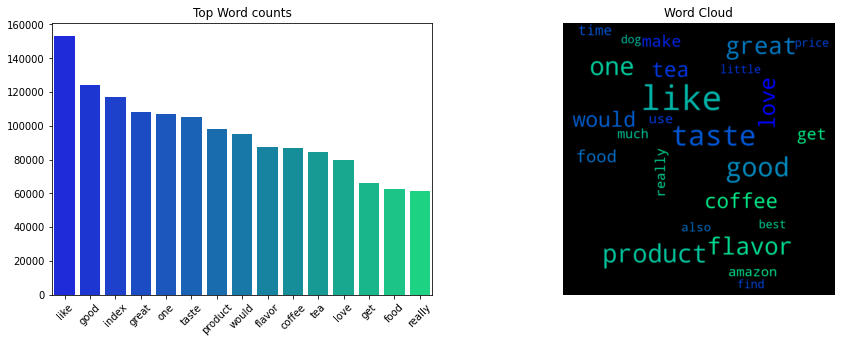

In [148]:
bar_and_cloud_generator(nostops_text_no_mods)

# Words from sentances labeled positive

All the way to product this is consistent to the total word count

43.68587851524353
60.06712985038757


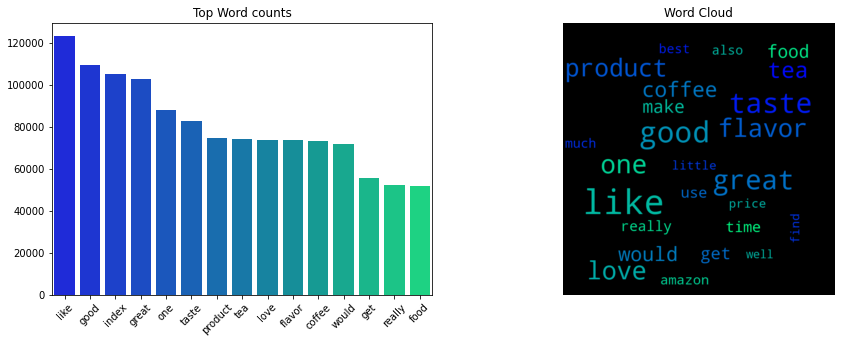

In [149]:
bar_and_cloud_generator(nostops_text_pos)

# Words from sentances labeled negative

9.208356380462646
12.51514220237732


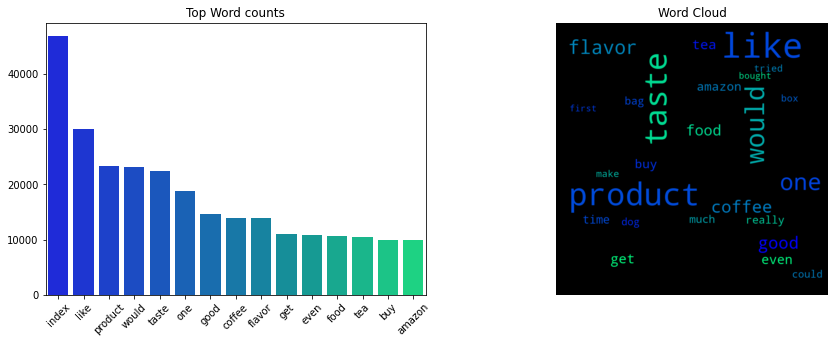

In [150]:
bar_and_cloud_generator(nostops_text_neg)

We can see there's considerable overlap between all three ways of organizing our corpus.

# n-gram/colocation analysis

https://www.nltk.org/howto/collocations.html

https://towardsdatascience.com/generating-colocations-n-grams-6dd8bea31d13

Documentation for how the association scores work
https://nlp.stanford.edu/fsnlp/promo/colloc.pdf

### All n-grams

In [177]:
start = time.time()
prototype_string = " ".join(df.text.sample(5))
stop = time.time()
print(str(stop-start))

0.054865121841430664


In [170]:
start = time.time()
big_string = " ".join(df.text.values)
stop = time.time()
print(str(stop-start))

6.6907737255096436


In [110]:
len(prototype_string)

145779807

In [128]:
start = time.time()
tri_finder = TrigramCollocationFinder.from_words(word_tokenize(prototype_string))
stop = time.time()
print(str(stop-start))

226.80234742164612


In [129]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
tri_finder.nbest(trigram_measures.pmi, 10)



[('aalouisiana', 'blendmexican', 'coatepec'),
 ('abamectin', 'fipronil', 'gentrol'),
 ('abortions', 'sigma', 'aldrich'),
 ('acidascorbic', 'acidpotassium', 'sorbatetartrazinetriacentrinyellow'),
 ('acidphosphoric', 'acidtartaric', 'acidtannic'),
 ('acidpotassium', 'sorbatetartrazinetriacentrinyellow', 'colorcloud'),
 ('acidsunflower', 'oilpotassium', 'sorbatei'),
 ('affidabile', 'spedizione', 'veloce'),
 ('ajl', 'fj', 'lakj'),
 ('alabamafloridageorgiaindianakentuckymassachusettsmarylandmichiganmississippinew',
  'yorknorth',
  'carolinaohiopennsylvaniasouth')]

In [132]:
tri_finder.apply_freq_filter(3)
type(tri_finder.nbest(trigram_measures.pmi, 10))

list

In [163]:
def bi_sorter(text,bi_freq=4,tri_freq=3):
    bi_start = time.time()
    #Tokenizes the string and sets up a finder
    bi_finder = BigramCollocationFinder.from_words(word_tokenize(text))
    #Initiates the scorer
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    #Culls infrequent bigrams
    bi_finder.apply_freq_filter(bi_freq)
    #finds likelihood ratios
    bi_likilhood_ratios = bi_finder.score_ngrams(bigram_measures.likelihood_ratio)
    #makes dict to land keys/scores in
    bi_assoc_measures = collections.defaultdict(list)
    #adds keys/scores to dict
    for key, scores in bi_likilhood_ratios:
       bi_assoc_measures[key[0]].append((key[1], scores))

    # Sort keyed bigrams by strongest association.                                  
    for key in prefix_keys:
       bi_assoc_measures[key].sort(key = lambda x: -x[1])
    
    bi_end = time.time()
  
    print('bigram dictionary took ' + str(bi_end-bi_start) + " seconds to build")

    
    return bi_assoc_measures

In [178]:
#This works, but builds an absolutely massive object, and takes an absurdely long time to build. May use it later, but for now
#it's not vital and I'd prefer not to be slowed down quite so much
def tri_sorter(text, tri_freq=3):
    tri_start = time.time()
    #Same thing but for trigrams!
     #Tokenizes the string and sets up a finder
    tri_finder = TrigramCollocationFinder.from_words(word_tokenize(text))
    #Initiates the scorer
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    #Culls infrequent bigrams
    tri_finder.apply_freq_filter(tri_freq)

    #finds likelihood ratios
    tri_likilhood_ratios = tri_finder.score_ngrams(trigram_measures.likelihood_ratio)
    #makes dict to land keys/scores in
    tri_assoc_measures = collections.defaultdict(list)
    #adds keys/scores to dict
    for key, scores in bi_likilhood_ratios:
       tri_assoc_measures[key[0]].append((key[1], scores))

    # Sort keyed trigrams by strongest association.                                  
    for key in prefix_keys:
       tri_assoc_measures[key].sort(key = lambda x: -x[1])
    tri_end = time.time()
    print('trigram dictionary took ' + str(tri_end-tri_start) + " seconds to build")
    return tri_assoc_measures

In [166]:
bigram_association_measures= bi_sorter(big_string)


bigram dictionary took 0.03500771522521973 seconds to build


In [180]:
#trigram_association_measures = tri_sorter(prototype_string)

trigram dictionary took 244.26743388175964 seconds to build


In [182]:
pickle.dump(bigram_association_measures, open( "bigram_association_measures", "wb" ) )

In [ ]:
#pickle.dump(trigram_association_measures, open( "trigram_association_measures", "wb" ) )

In [188]:

print( 'coffee', bigram_association_measures['coffee'][:5])
print( 'good', bigram_association_measures['good'][:5])
print( 'taste', bigram_association_measures['taste'][:5])

coffee []
good []
taste []


### Postiive Text Collocations

In [185]:
text_pos = " ".join(" ".join(listo) for listo in df.text[df['Y'] == 1])

In [187]:
pos_bigram_association_measures= bi_sorter(text_pos)


240752263

In [ ]:
pickle.dump(pos_bigram_association_measures, open( "pos_bigram_association_measures", "wb" ) )

### Negative Text Collocations

In [ ]:
text_neg = " ".join(" ".join(listo) for listo in df.text[df['Y'] == 0])

In [ ]:
neg_bigram_association_measures= bi_sorter(text_neg)


In [ ]:
pickle.dump(neg_bigram_association_measures, open( "neg_bigram_association_measures", "wb" ) )

#DF Pickle Test

In [ ]:
pickle.dump(df, open( "built_out_df", "wb" ) )

## Clustering and Secondary EDA

We played briefly with using DBSCAN, but it didn't converge at all, it gave us 360k categories

Thinking that instead of conventional clustering we're going to play with latent dirichlet allocation because it'll do a similar thing as K-means, but also provide us with a lot more information about the composition of those clusters.
Original Paper: https://ai.stanford.edu/~ang/papers/nips01-lda.pdf
Tutorial we used to help us get going: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
Docs for the gensim module we're sdoing the lda with: https://radimrehurek.com/gensim/models/ldamodel.html

In [ ]:
#Tools for lDA visualization

#Normally I like to my imports at the top of a ntoebook, but these imports make the
#notebook spam an annoying warning that I can only fix by downgrading some stuff, which I am disinclined to do.
import pyLDAvis.gensim_models 
import pickle 
import pyLDAvis

In [ ]:
stemmed_texts = list(df.stemmed)

In [ ]:
#makes a dictionary mapping to unique IDs
id2word = Dictionary(stemmed_texts)


In [ ]:
#makes a bag of words version of the Gensim Dictionary
corpus = [id2word.doc2bow(text) for text in stemmed_texts]


In [ ]:
# Train the model on the corpus.
num_topics = 10
lda = LdaModel(corpus,  id2word=id2word, num_topics=num_topics)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

if 1 == 0:
    LDAvis_prepared = pyLDAvis.gensim_models .prepare(lda, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

This is pretty neat, but honestly I don't care very much. These distributions don't really affect what I'm about to do. I was just curious to try this.

We might do something similar to the earlier word clouds and break this up by sentiment. SEe if the clusters are significantly different across sentiments, but again it's not deeply relevant to our long term goals, so we may not take the time